In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Risk Factor plot

In [2]:
rs_values = []
delta_values = []
for i in range(-600, 250, 50):
    delta = (200 + i)*5000 / 1_000_000
    delta_values.append(delta)

    pos = 200 * 5000 * (1+0.2) + i * 5000* 0.2 + 1_000_000
    neg = 200 * 5000 *(1-0.2) + i * 5000* -0.2 + 1_000_000
    rs = min(pos, neg)
    rs_values.append(rs/1_000_000)

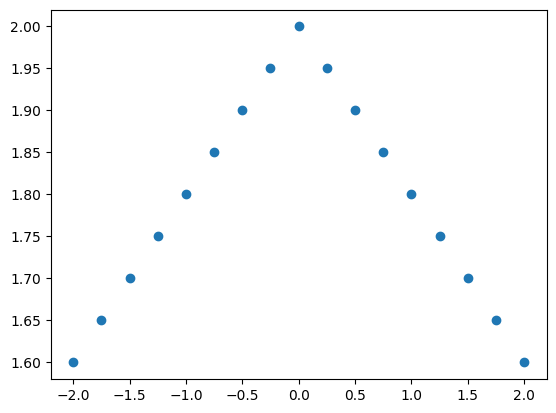

In [3]:
plt.scatter(delta_values, rs_values)

## LST performance 

In [40]:
eth_usd = pd.read_csv("data/ETH-USD.csv", index_col=0, parse_dates=[0])

In [70]:
eth_usd

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-01,1671.161499,1750.595703,1670.082153,1733.810425,1733.810425,5054880180
2023-10-02,1732.984009,1743.563599,1646.077637,1663.627563,1663.627563,8420552922
2023-10-03,1662.887207,1670.356323,1644.496460,1656.685669,1656.685669,4742827302
2023-10-04,1656.735962,1657.253540,1629.426636,1647.838135,1647.838135,5127524863
2023-10-05,1647.788208,1654.379028,1609.849976,1611.476440,1611.476440,5403759057
...,...,...,...,...,...,...
2024-05-02,2969.794434,3015.050293,2894.329834,2988.168457,2988.168457,13163903903
2024-05-03,2988.134521,3127.155273,2960.182129,3103.541992,3103.541992,12862183229
2024-05-04,3103.619629,3167.541260,3096.267578,3117.576416,3117.576416,8283229638


In [83]:
eth_usd = eth_usd.loc['2023-10-01':]

In [124]:
LST_yield = 0.04
LRT_yield = 0.1
PENDLE_PT_APY = 0.4
funding_apy = 0.1
borrowed_amount = 1_000_000 # in USDT 
initial_eth_price = eth_usd.iloc[0]['Close']
collateral_value = borrowed_amount / initial_eth_price
hedge_position = -collateral_value # hedge initial exposure by taking short position.

In [125]:
collateral_value

576.7643253154392

In [126]:
naive_token_position = pd.Series(index=eth_usd.index)
naive_token_position[:] = collateral_value
lst_token_position = naive_token_position.copy()
lrt_token_position = naive_token_position.copy()
pt_token_position = naive_token_position.copy()

In [127]:
hedge_performance = hedge_position * (eth_usd['Close'] - eth_usd['Close'].iloc[0])
hedge_funding_accrued = -hedge_position * eth_usd['Close'] * (1*funding_apy)/365
hedge_funding_accrued = hedge_funding_accrued.cumsum()

In [128]:
lst_apy = lst_token_position.copy()
lst_apy[:] = 0
lst_apy += 1/365 * LST_yield
lst_token_position *= (1+lst_apy.cumsum())

In [129]:
lrt_apy = lrt_token_position.copy()
lrt_apy[:] = 0
lrt_apy += 1/365 * LRT_yield
lrt_token_position *= (1+lrt_apy.cumsum())

In [130]:
pendle_apy = pt_token_position.copy()
pendle_apy[:] = 0
pendle_apy += 1/365 * PENDLE_PT_APY
pt_token_position *= (1+pendle_apy.cumsum())

<Axes: xlabel='Date'>

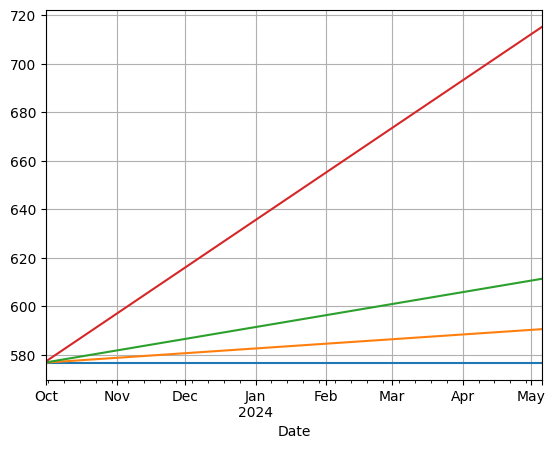

In [133]:
naive_token_position.plot(grid=True)
lst_token_position.plot(grid=True)
lrt_token_position.plot(grid=True)
pt_token_position.plot(grid=True)

In [134]:
naive_backtest = borrowed_amount + naive_token_position*eth_usd['Close'] + hedge_performance + hedge_funding_accrued
lst_backtest = borrowed_amount + lst_token_position*eth_usd['Close'] + hedge_performance + hedge_funding_accrued
lrt_backtest = borrowed_amount + lrt_token_position*eth_usd['Close'] + hedge_performance + hedge_funding_accrued
pendle_backtest = borrowed_amount + pt_token_position*eth_usd['Close'] + hedge_performance + hedge_funding_accrued

<Axes: xlabel='Date'>

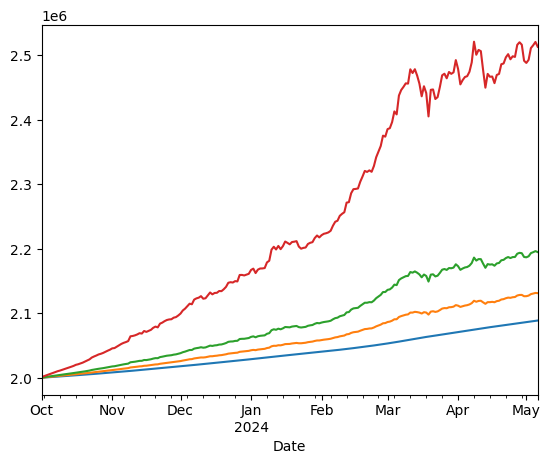

In [135]:
naive_backtest.plot()
lst_backtest.plot()
lrt_backtest.plot()
pendle_backtest.plot()

In [138]:
naive_dollar_invested = ((borrowed_amount+naive_backtest.diff().cumsum())/borrowed_amount)
lst_dollar_invested = ((borrowed_amount+lst_backtest.diff().cumsum())/borrowed_amount)
lrt_dollar_invested = ((borrowed_amount+lrt_backtest.diff().cumsum())/borrowed_amount)
pendle_dollar_invested = ((borrowed_amount+pendle_backtest.diff().cumsum())/borrowed_amount)

<Axes: xlabel='Date'>

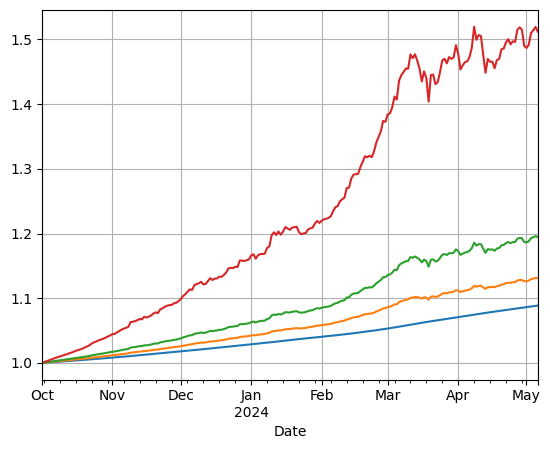

In [139]:
naive_dollar_invested.plot(grid=True)
lst_dollar_invested.plot(grid=True)
lrt_dollar_invested.plot(grid=True)
pendle_dollar_invested.plot(grid=True)

In [155]:
apy_naive = (naive_dollar_invested.iloc[-1]-1) * 365/naive_dollar_invested.shape[0]
apy_lst = (lst_dollar_invested.iloc[-1]-1) * 365/lst_dollar_invested.shape[0]
apy_lrt = (lrt_dollar_invested.iloc[-1]-1) * 365/lrt_dollar_invested.shape[0]
apy_pendle = (pendle_dollar_invested.iloc[-1]-1) * 365/pendle_dollar_invested.shape[0]

In [156]:
apy_naive, apy_lst, apy_lrt, apy_pendle

(0.14775632961915347,
 0.21828729681921769,
 0.3240837476193133,
 0.8530660016197885)